# Task 3. Label Placement

## Выполнил Курузов Илья

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pysat.solvers import Glucose3

In [2]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

Классы `Pos` и `Box` являются модифицированными классами, написанными Игорем Дьяченко и предоствленными в общем телеграмм канале. Для дальнейшей работы, мне удобней работать, когда позиция задается нижним левым углом, из-за чего и пришлось вносить коррективы.

In [3]:
class Pos:
    def __init__(self, *arr):
        assert len(arr) == 2
        self.xy = np.array(arr)
    
    def __add__(self, that):
        return [a + b for a, b in zip(self.xy, that.xy)]
    
    def __sub__(self, that):
        return [a - b for a, b in zip(self.xy, that.xy)]
    
    def __neg__(self):
        return [-a for a in self.xy]
    
    def __str__(self):
        return str(self.xy)
    
    def __repr__(self):
        return str(self)
    
    def parse(s):
        arr = [int(a) for a in s.split(',')]
        return Pos(*arr)


class Box:
    def __init__(self, line):
        arr = line.split('\t')
        self.pos = Pos.parse(arr[0])
        self.size = Pos.parse(arr[1])
        self.offsets = [Pos.parse(pos) for pos in arr[2].split(' ')]
        for offset in self.offsets:
            offset.xy += self.pos.xy - self.size.xy
        assert len(self.offsets) > 0
    
    def __str__(self):
        return 'Box(pos={}, size={}, offsets={})'.format(self.pos, self.size, self.offsets)
    
    def __repr__(self):
        return str(self)

In [4]:
def parse_raw_data(raw_data):
    boxes = [Box(line) for line in raw_data.strip().split('\n')]
    return boxes

Реализуем метод для произвольного количества возможных положений подписи.

Пусть есть $n$ точек, для $j$-ой точки есть $k_j\geq 1$ возможных положений подписи. Тогда заведем $\sum\limits_{j=1}^n k_j$ булевских переменных вида $x_{i, j}$ - стоит ли на $j$-ом месте для $i$-ой точки подпись.

Пусть $A_{i,j}$ - множество точек, которое покроет $j$-ое положение подписи $i$-ой точки.

Определим множество конфликтных пар $$K=\left\{((i_1, j_1), (i_2, j_2)):\substack{i_1\neq i_2\\
A_{i_1,j_1}\cap A_{i_2,j_2}\neq \emptyset}\right\}.$$

В таком случае нужно проверить выполнимость булевской формулы.

$$\bigwedge\limits_{j=1}^n \left(\bigvee\limits_{i=1}^{k_j} x_{j,i}\right) \bigwedge \bigwedge\limits_{(\alpha,\beta)\in K} \left(\overline{x_{\alpha}}\vee \overline{x_{\beta}}\right)$$

Левая часть отвечает за то, чтобы у каждой точки была подпись, правая - за отсутсвие конфликтов.

Заметим, что в данной концепции выполняющий набор может содержать больше одной единицы в наборе переменных $\{x_{j,i}\}_i$ для некоторого $j$. В таком случае, в качестве решения мы выберем лексигрофически первое положение.

In [5]:
def cap(size1, pos1, size2, pos2):
    if pos1[1] > pos2[1]:
        # After that the first element is under the second
        size1, pos1, size2, pos2 = size2, pos2, size1, pos1
    hr1 = pos1 + size1
    hr2 = pos2 + size2
    if hr1[1] < pos2[1]:
        # The first position is under the second without intersection
        return False
    if hr1[0] < pos2[0] or pos1[0] > hr2[0]:
        return False
    return True

def ind_cap(size1, offset1, size2, offset2):
    res = []
    for ind1, pos1 in enumerate(offset1):
        for ind2, pos2 in enumerate(offset2):
            if cap(size1.xy, pos1.xy, size2.xy, pos2.xy):
                res.append((ind1, ind2))
    return res
            

def get_model(boxes):
    variables = {}
    s = 1
    clauses = []
    for ind_box, box in enumerate(boxes):
        cur_clause = []
        for ind_set, _ in enumerate(box.offsets):
            variables[(ind_box, ind_set)] = s
            cur_clause.append(s)
            s += 1
        clauses.append(cur_clause)
    for ind_i, i in enumerate(boxes):
        for ind_j, j in enumerate(boxes):
            if ind_i != ind_j:
                K = ind_cap(i.size, i.offsets, j.size, j.offsets)
                for i_o, j_o in K:
                    a = variables[(ind_i, i_o)]
                    b = variables[(ind_j, j_o)]
                    clauses.append([-1 * a, -1 * b])
    return variables, clauses

Для решения проблемы SAT будем использовать пакет PySAT.

In [6]:
def solve_SAT(clauses):
    g = Glucose3()
    [g.add_clause(clause) for clause in clauses]
    g.solve()
    return g.get_model()

In [7]:
def parse_solution(solution, variables, boxes):
    if solution is None:
        return None
    pos = []
    for ind, box in enumerate(boxes):
        for j, offset in enumerate(box.offsets):
            if variables[(ind, j)] in solution:
                pos.append(j)
                break
    return pos

In [8]:
def plot_pos(boxes, pos, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
    for ind, box in enumerate(boxes):
        ax.add_patch(Rectangle(box.offsets[pos[ind]].xy, box.size.xy[0], box.size.xy[1], 
                               linewidth=1, edgecolor='r', facecolor='None'))
    x = [box.pos.xy[0] for box in boxes]
    y = [box.pos.xy[1] for box in boxes]
    plt.scatter(x, y)
    plt.show()

In [9]:
def process_file(file_name):
    with open(file_name, "r") as f:
        raw_data = f.read()
    boxes = parse_raw_data(raw_data)
    print("Boxes:")
    for ind, box in enumerate(boxes):
        print(ind, box)
    variables, clauses = get_model(boxes)

    solution = solve_SAT(clauses)
    if solution is None:
        print("There is not label placement")
    pos = parse_solution(solution, variables, boxes)
    plot_pos(boxes,pos)
    plt.show()

Boxes:
0 Box(pos=[45 15], size=[20 10], offsets=[[25  5], [45  5], [25 15], [45 15]])
1 Box(pos=[50 15], size=[20 10], offsets=[[30  5], [50  5], [30 15], [50 15]])
2 Box(pos=[25 30], size=[20 10], offsets=[[ 5 20], [25 20], [ 5 30], [25 30]])
3 Box(pos=[30 20], size=[20 10], offsets=[[10 10], [30 10], [10 20], [30 20]])
4 Box(pos=[55 20], size=[20 10], offsets=[[35 10], [55 10], [35 20], [55 20]])
5 Box(pos=[40 35], size=[20 10], offsets=[[20 25], [40 25], [20 35], [40 35]])
6 Box(pos=[45 35], size=[20 10], offsets=[[25 25], [45 25], [25 35], [45 35]])


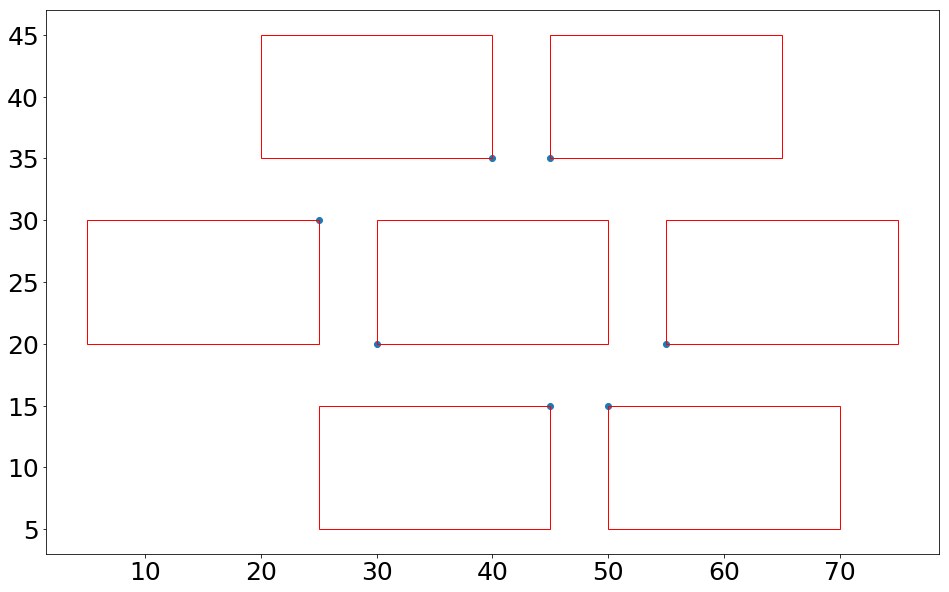

In [10]:
%matplotlib inline
process_file("bricks.txt")

Boxes:
0 Box(pos=[25 20], size=[10 10], offsets=[[15 10], [25 10], [15 20], [25 20]])
1 Box(pos=[25 40], size=[10 30], offsets=[[15 10], [25 10], [15 25], [25 25], [15 40], [25 40]])
2 Box(pos=[25 60], size=[10 10], offsets=[[15 50], [25 50], [15 60], [25 60]])
3 Box(pos=[40 25], size=[20 10], offsets=[[20 15], [30 15], [40 15], [20 25], [30 25], [40 25]])
4 Box(pos=[40 40], size=[20 20], offsets=[[20 20], [30 20], [40 20], [20 30], [30 30], [40 30], [20 40], [30 40], [40 40]])
5 Box(pos=[40 55], size=[20 10], offsets=[[20 45], [30 45], [40 45], [20 55], [30 55], [40 55]])
6 Box(pos=[55 35], size=[10 20], offsets=[[45 15], [55 15], [45 25], [55 25], [45 35], [55 35]])
7 Box(pos=[55 40], size=[10 20], offsets=[[45 20], [55 20], [45 30], [55 30], [45 40], [55 40]])


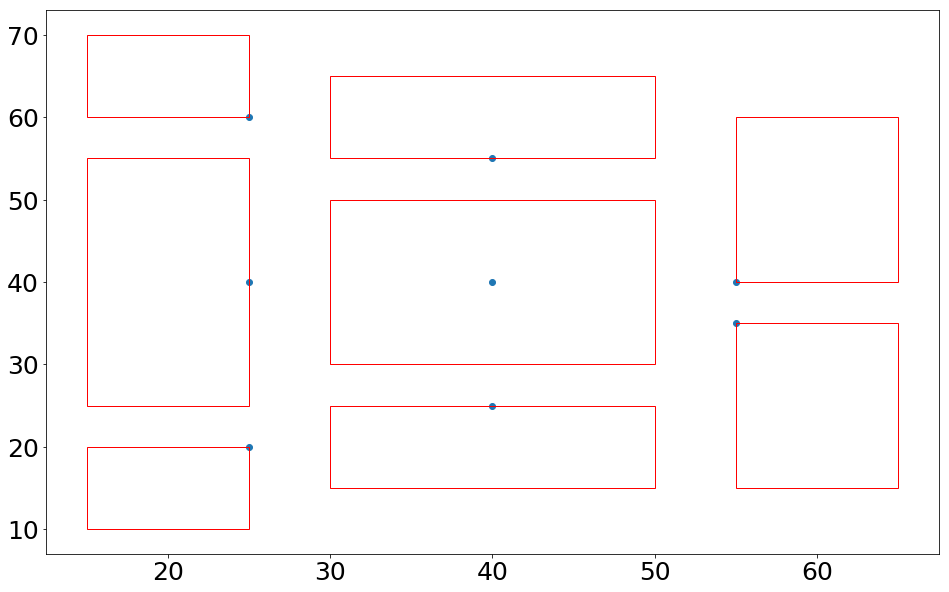

In [11]:
%matplotlib inline
process_file("frame.txt")

Boxes:
0 Box(pos=[20 20], size=[10 10], offsets=[[10 10], [20 10], [10 20], [20 20]])
1 Box(pos=[20 25], size=[10 10], offsets=[[10 15], [20 15], [10 25], [20 25]])
2 Box(pos=[25 20], size=[10 10], offsets=[[15 10], [25 10], [15 20], [25 20]])
3 Box(pos=[25 25], size=[10 10], offsets=[[15 15], [25 15], [15 25], [25 25]])


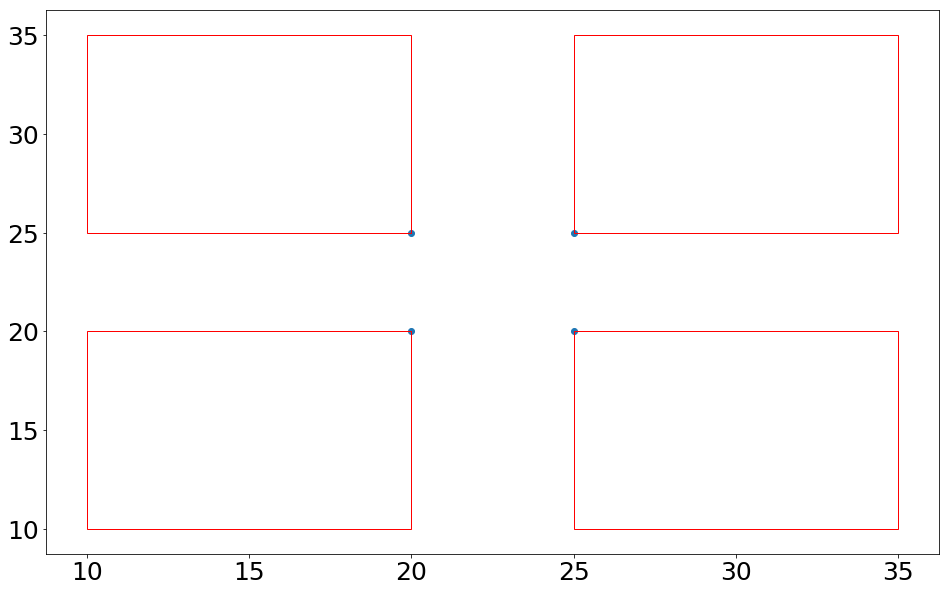

In [12]:
%matplotlib inline
process_file("test4.txt")

Boxes:
0 Box(pos=[20 20], size=[10 10], offsets=[[10 10], [20 10], [10 20], [20 20]])
1 Box(pos=[20 25], size=[10 10], offsets=[[10 15], [20 15], [10 25], [20 25]])
2 Box(pos=[25 20], size=[10 10], offsets=[[15 10], [25 10], [15 20], [25 20]])
3 Box(pos=[25 25], size=[10 10], offsets=[[15 15], [25 15], [15 25], [25 25]])
4 Box(pos=[20 60], size=[10 10], offsets=[[10 50], [20 50], [10 60], [20 60]])
5 Box(pos=[20 65], size=[10 10], offsets=[[10 55], [20 55], [10 65], [20 65]])
6 Box(pos=[25 60], size=[10 10], offsets=[[15 50], [25 50], [15 60], [25 60]])
7 Box(pos=[25 65], size=[10 10], offsets=[[15 55], [25 55], [15 65], [25 65]])
8 Box(pos=[60 20], size=[10 10], offsets=[[50 10], [60 10], [50 20], [60 20]])
9 Box(pos=[60 25], size=[10 10], offsets=[[50 15], [60 15], [50 25], [60 25]])
10 Box(pos=[65 20], size=[10 10], offsets=[[55 10], [65 10], [55 20], [65 20]])
11 Box(pos=[65 25], size=[10 10], offsets=[[55 15], [65 15], [55 25], [65 25]])
12 Box(pos=[60 60], size=[10 10], offsets=[

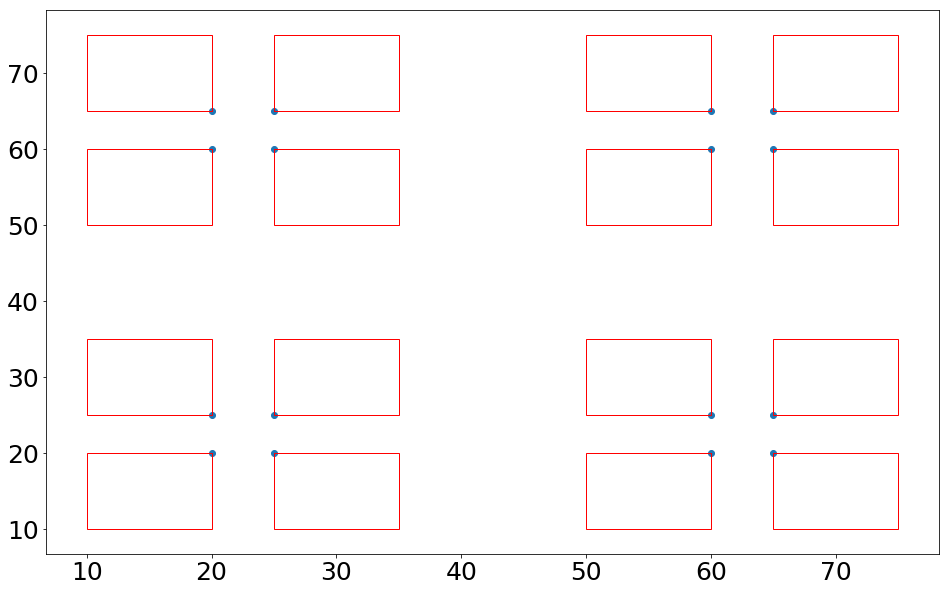

In [13]:
%matplotlib inline
process_file("test16.txt")